In [1]:
import scipy
import numpy as np
from fitters import *
from tools import *
from plots import *
from trainer import *
set_seaborn()
sns.set_theme()
%load_ext autoreload
%autoreload 2


In [2]:
resPH, stimPH = read_lmc('PHOTO')
res1, stim3 = read_lmc('LMC-BG1')
res2, stim3 = read_lmc('LMC-BG2')
res3, stim3 = read_lmc('LMC-BG3')
res4, stim4 = read_lmc('LMC-BG4')
res5, stim5 = read_lmc('LMC-BG5')
res6, stim6 = read_lmc('LMC-BG6')

TIME = 1.0
all_results = []

In [3]:
def get_data(Ydataset, factor, Xdataset='PHOTO'):
    resX, stim = read_lmc(Xdataset)
    resY, stim = read_lmc(Ydataset)
    X = preprocess(resX, factor=factor, method='mean')
    Y = preprocess(resY, factor=factor, method='mean')

    return X, Y


In [4]:
def convert_dtms_windowms_to_factor_dim(dt, window, TIME=1.0, LEN=10000):
    orignal_dt_ms = TIME/LEN * 1000
    factor = int(dt/orignal_dt_ms)
    dim = int(window / dt)
    return factor, dim


In [5]:

def test_run(beta=0, dt_ms=1.0, window_ms=50, dataset=''):


    factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, window_ms)

    X_series, Y_series = get_data(dataset, factor)


    # ALGO
    Xhan = build_hankel(X_series, dim)
    X0 = Xhan[:, :-1]
    Xp = Xhan[:, 1:]
    lam = beta * np.eye(dim)

    X0Xp = X0 @ Xp.T
    X0X0 = X0 @ X0.T
    # solve eigenvalue problem
    w, vl = scipy.linalg.eig(
        X0Xp, (X0X0+lam), overwrite_a=True, overwrite_b=True)

    theta = vl[:, np.nanargmax(np.abs(w))]
    w = np.sort(np.abs(w))[::-1]

    theta /= theta[-1]
    pred_eig = theta.real @ Xhan
    pred_eig /= pred_eig[0]

    # X Corr
    X_centered = X_series - X_series.mean()
    XXT = np.outer(X_centered, X_centered.T)
    wXXt = np.sort(scipy.linalg.eig(XXT)[0])[::-1]

    time = np.linspace(0,1,len(X_series))

    result = {
        'Time-X': time,
        'Time-Y': time[dim:],
        'Time-Filter': np.linspace(-window_ms, 0, dim),
        'X_series': X_series,
        'Y_series': Y_series[dim:],
        'Pred Eig Left': pred_eig,
        'Eig Vec (REAL)': theta.real,
        'Eig Vec (IMAG)': theta.imag,
        'Eig Vals (MAG)': np.abs(w),
        'Eig Vals (REAL)': w.real,
        'Eig Vals (IMAG)': w.imag,
        'Spec X@XT': wXXt,
    }
    return result


In [6]:
ALL_DATA = ['LMC-BG1', 'LMC-BG2', 'LMC-BG3', 'LMC-BG4', 'LMC-BG5', 'LMC-BG6']
params = {
    'dataset': ['LMC-BG3'],
    'beta': [10, 1, 1e-1, 1e-4, 0],
    'dt_ms': [1.0],
    'window_ms': [100, 50, 25, 12],

}
results = param_runner(test_run, params)


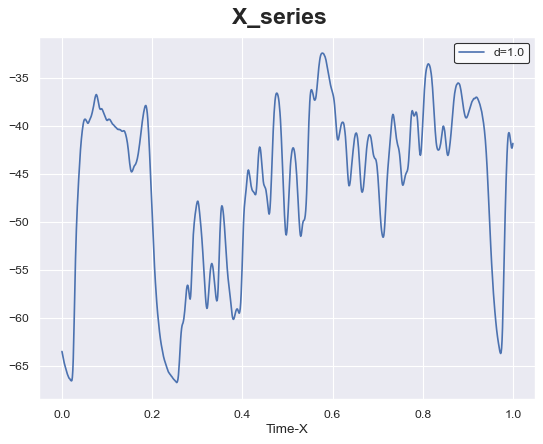

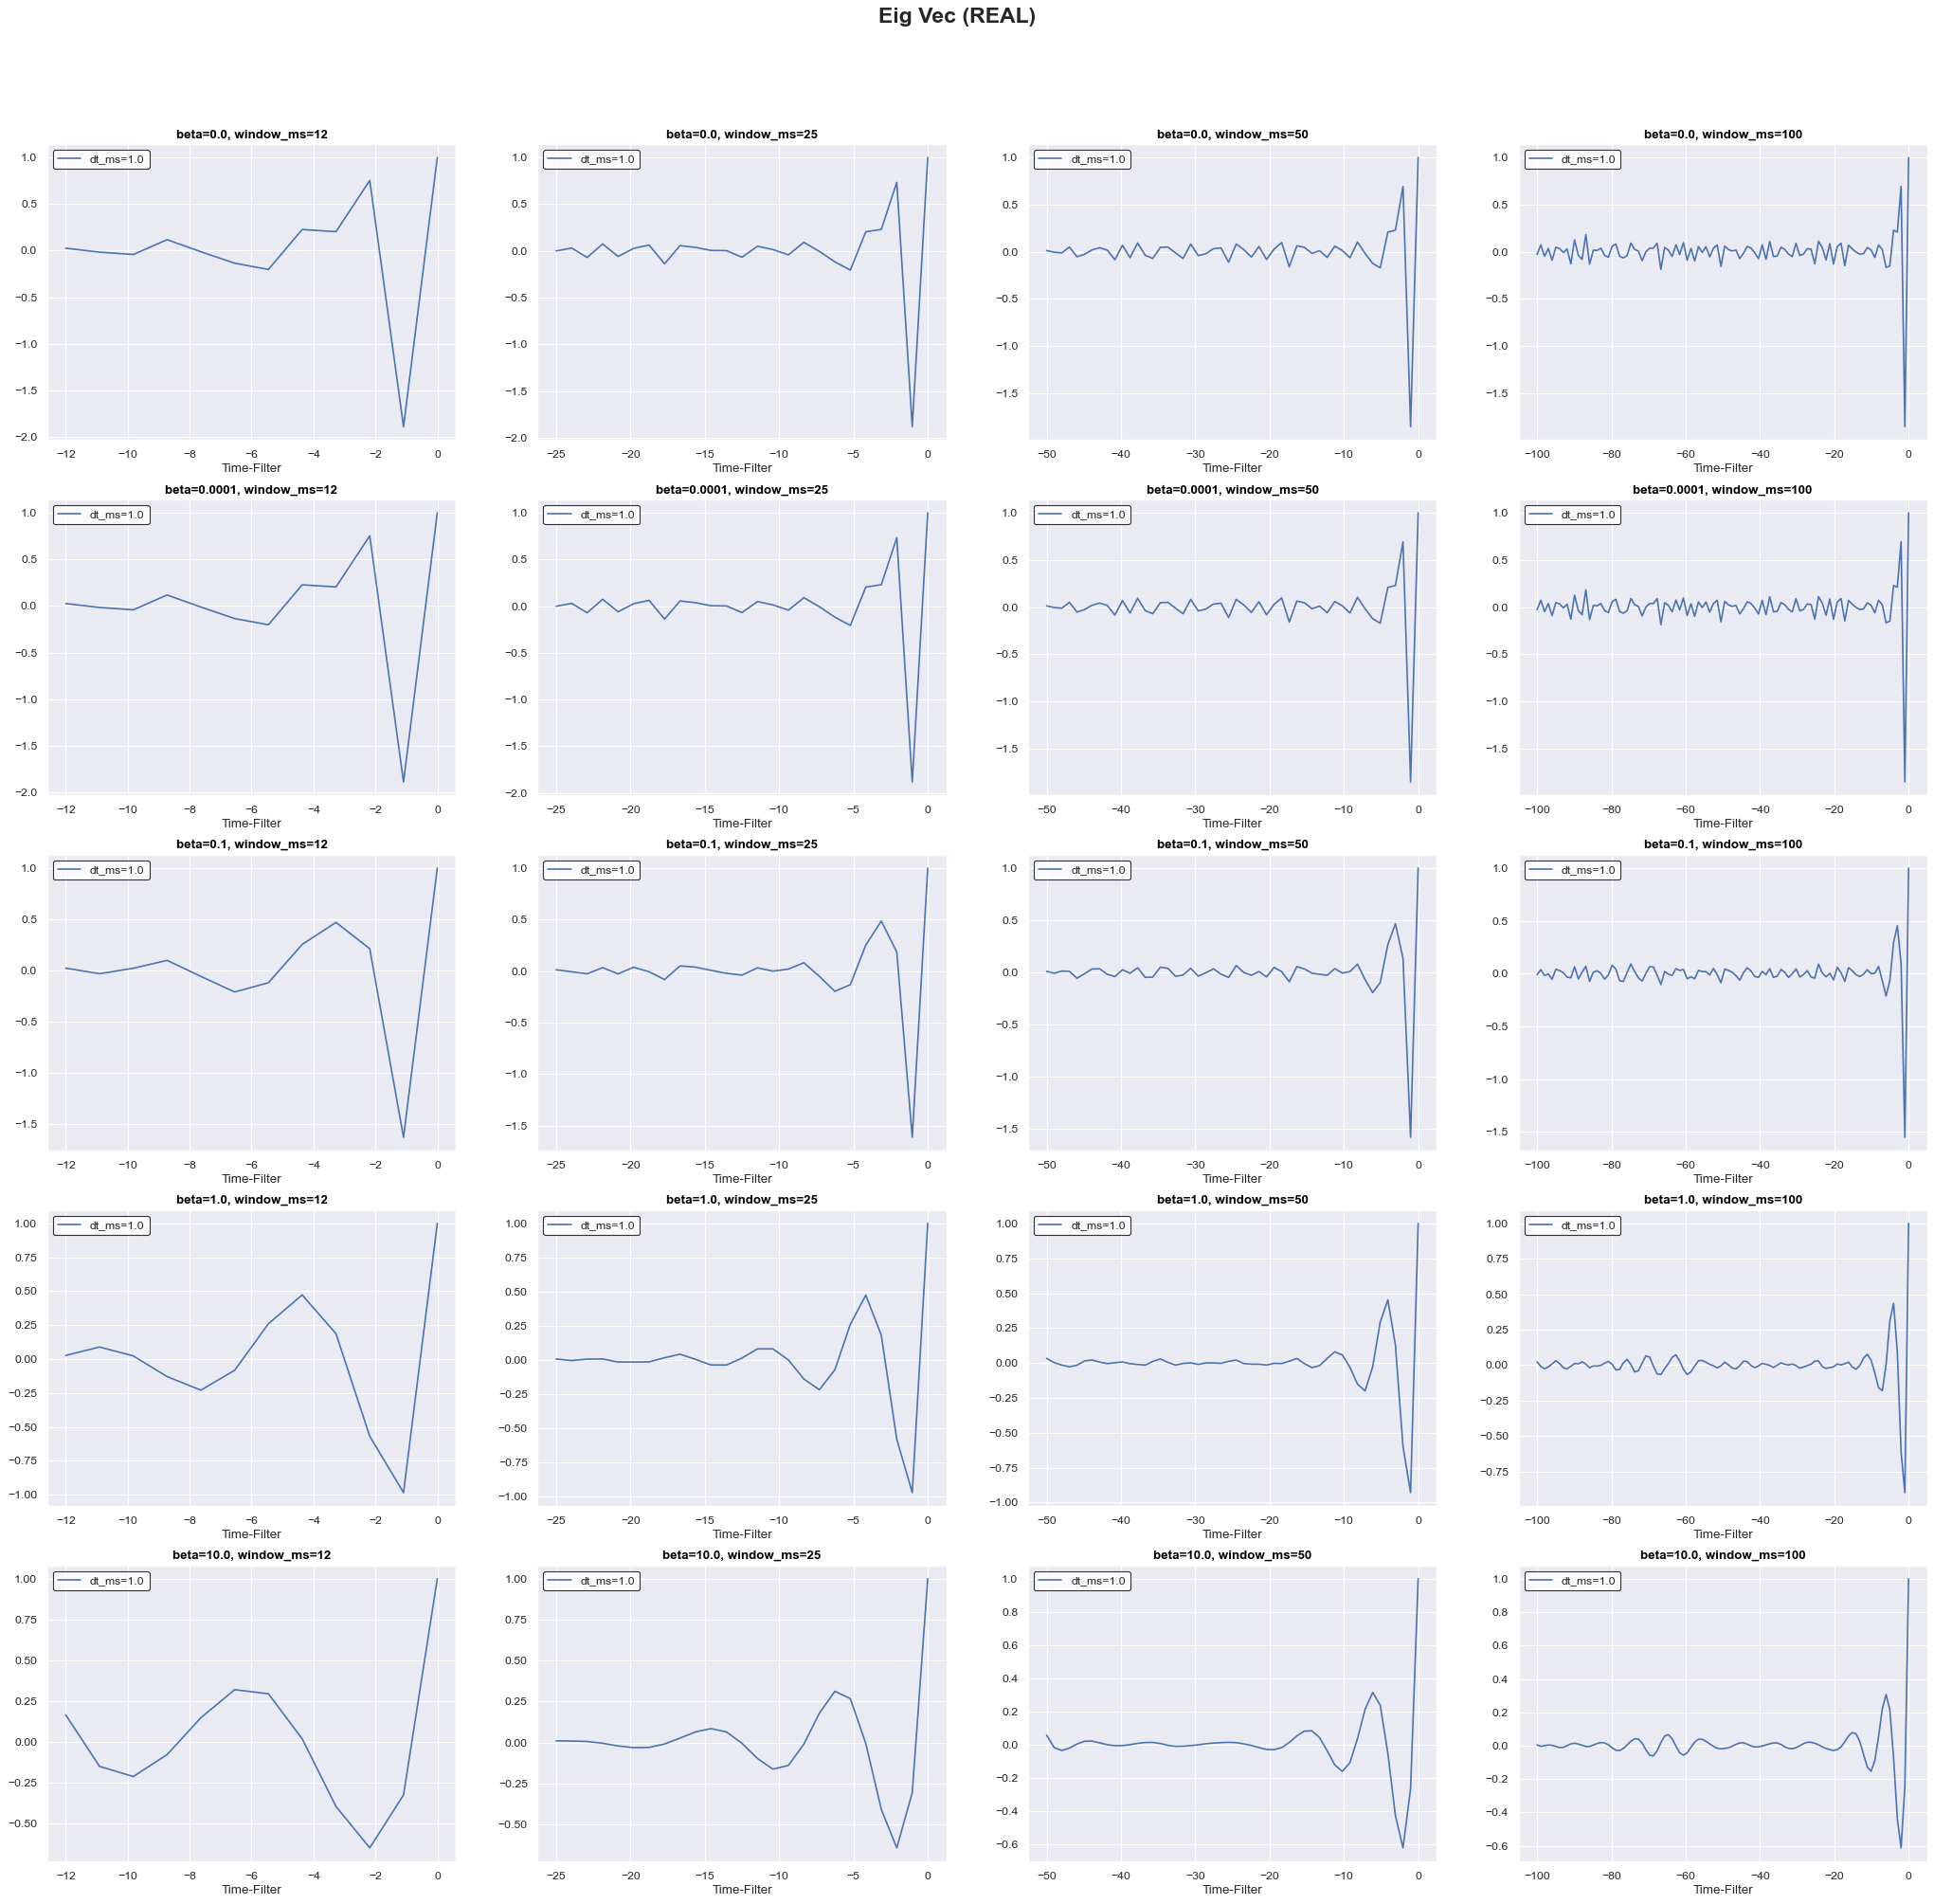

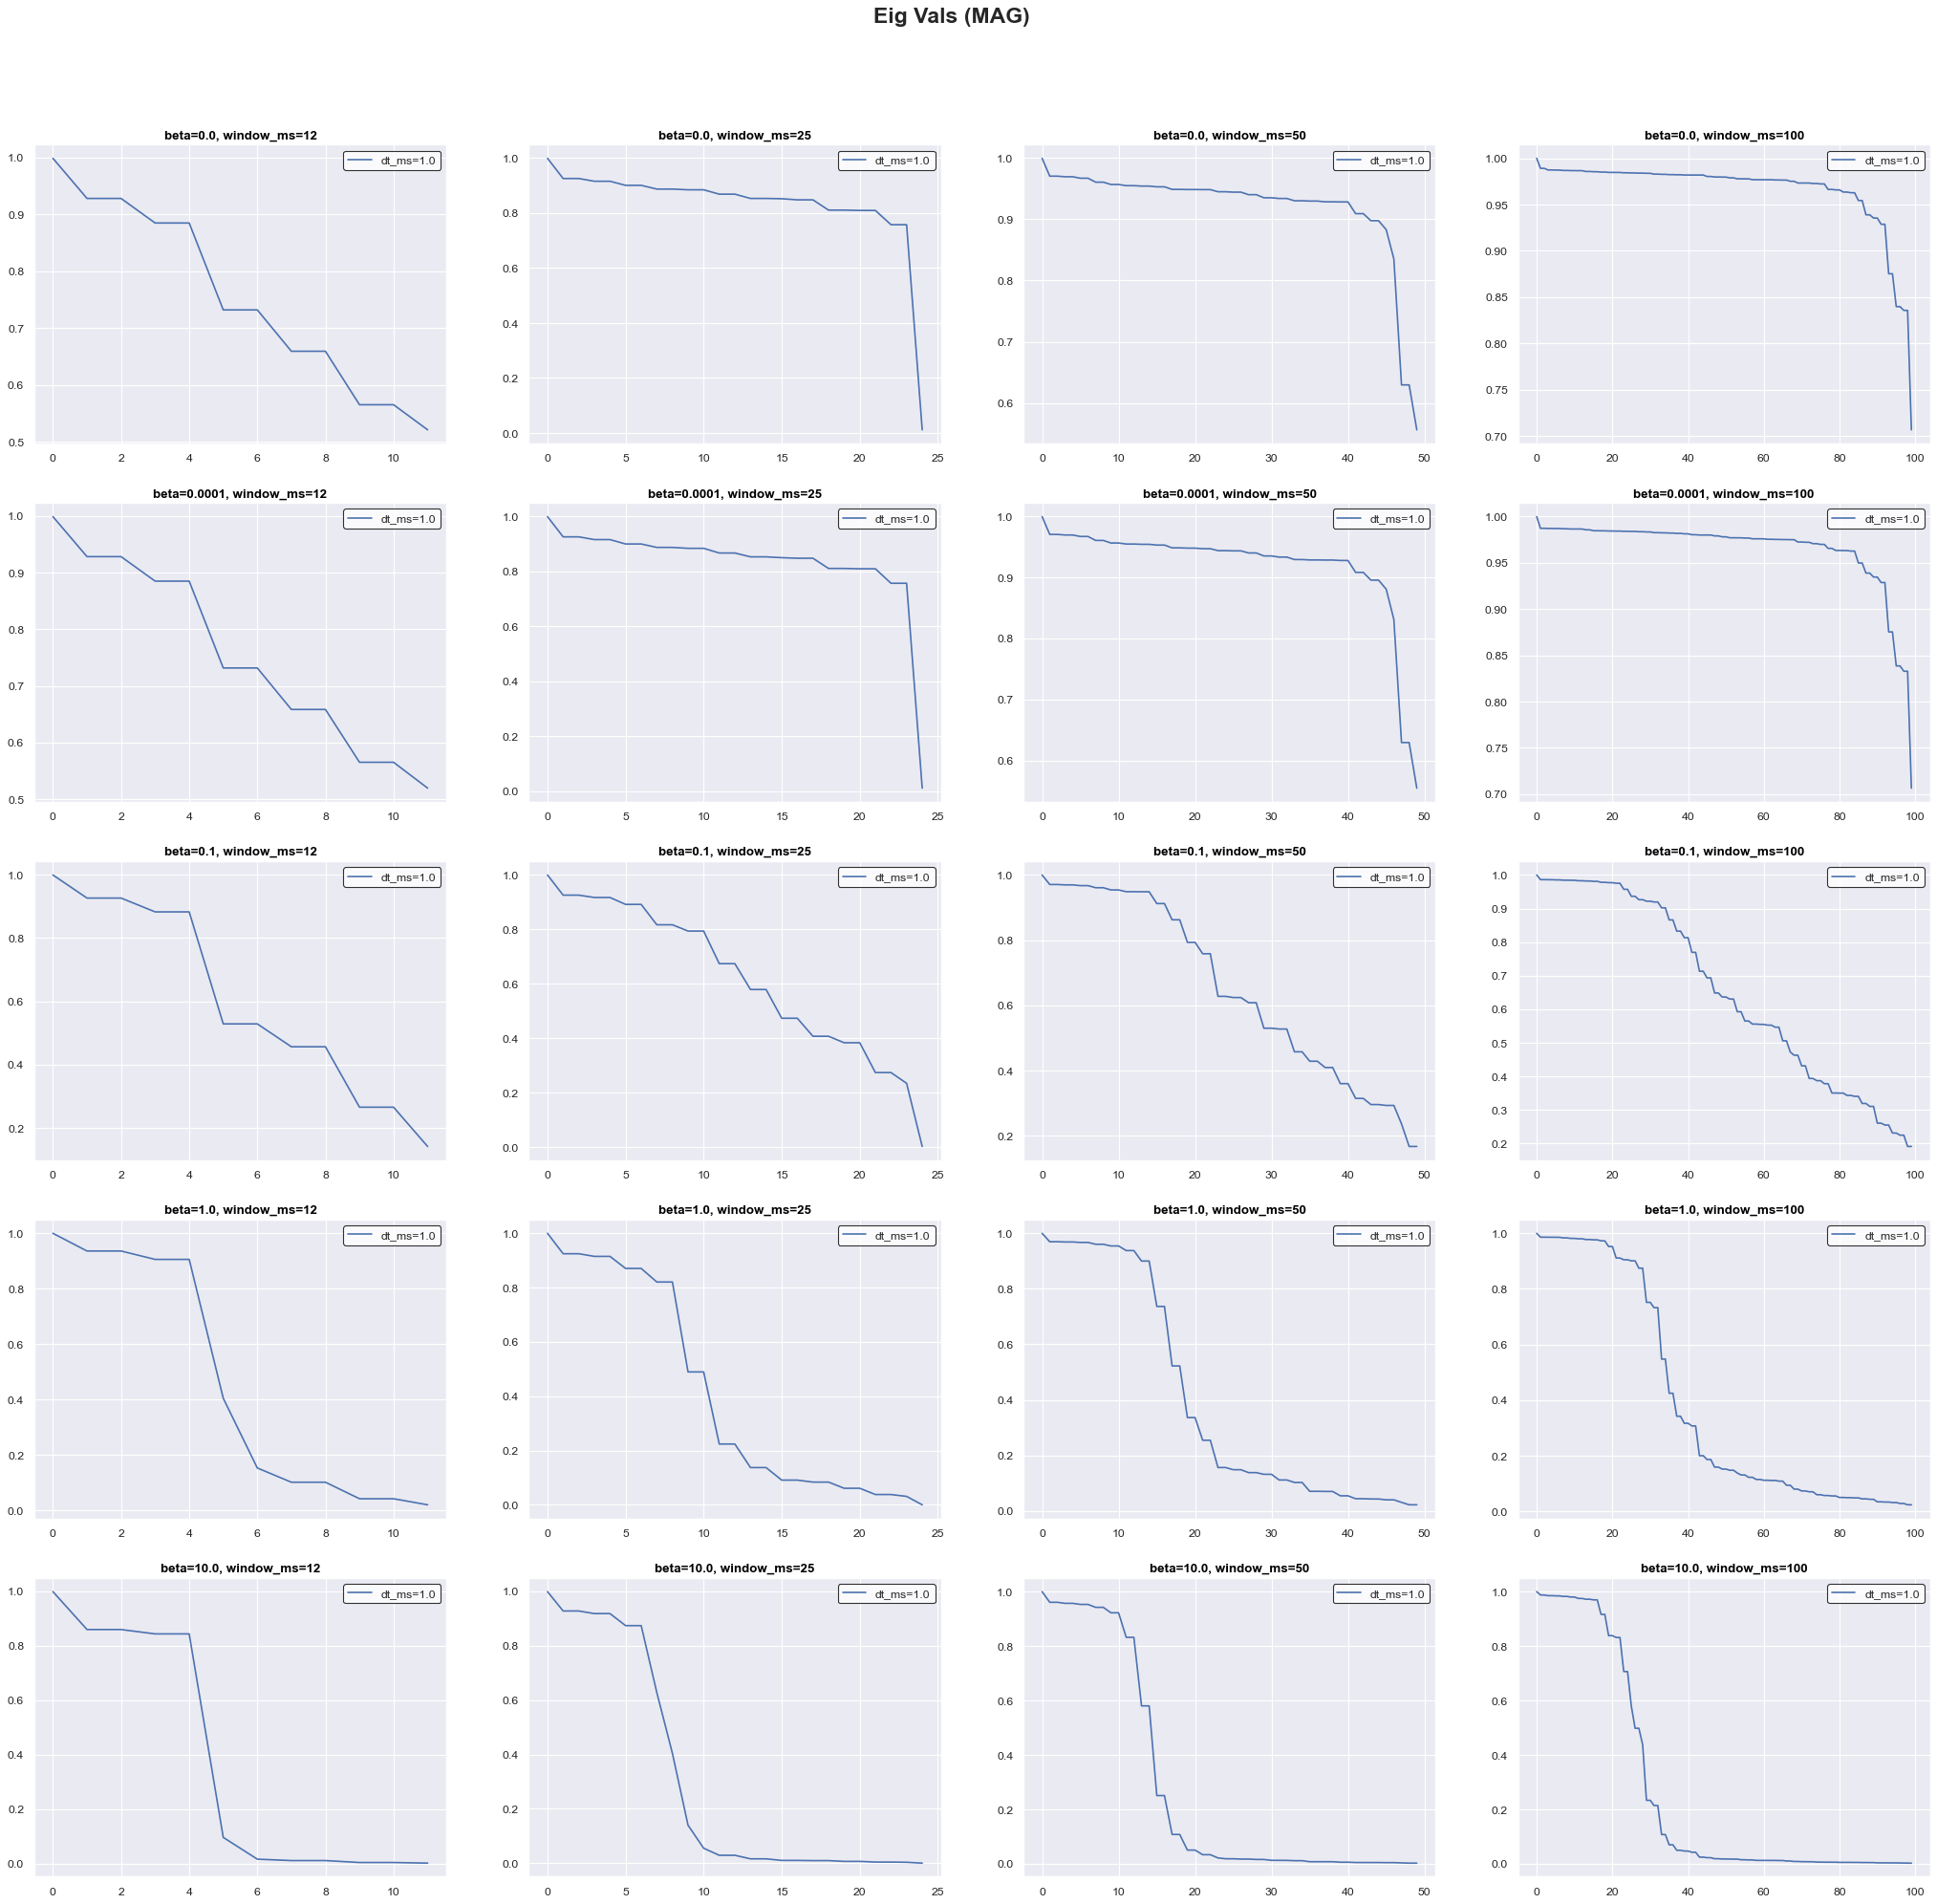

In [8]:
plot_dataframe(results, 'X_series', x_col='Time-X', line_cols='dt_ms', aggregate='last')
plot_dataframe(results, 'Eig Vec (REAL)', x_col='Time-Filter', line_cols=['dt_ms'], title_cols=['beta', 'window_ms'], aggregate='error')
plot_dataframe(results, 'Eig Vals (MAG)', line_cols=['dt_ms'], title_cols=['beta', 'window_ms'], aggregate='error')